## Estimation of covariance matrix

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"


plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

import pandas as pd


In [3]:
with open('gaussian_fit.stan', 'r') as file:
    print(file.read())

data {
  int<lower=1> N; // number of observations
  int<lower=1> J; // dimension of observations
  vector[J] y[N]; // observations
  vector[J] Zero; // a vector of Zeros (fixed means of observations)
}
parameters {
  cholesky_factor_corr[J] Lcorr;
  vector<lower=0>[J] sigma;
}
model {
  y ~ multi_normal_cholesky(Zero, diag_pre_multiply(sigma, Lcorr));
  sigma ~ exponential(1);
  Lcorr ~ lkj_corr_cholesky(10);
}
generated quantities {
  matrix[J,J] Omega;
  matrix[J,J] Sigma;
  Omega = multiply_lower_tri_self_transpose(Lcorr);
  Sigma = quad_form_diag(Omega, sigma);
}



In [4]:
model_lkj=CmdStanModel(stan_file='gaussian_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmprp8co5sw/tmp4etkfjem
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 5 - Multiparameter models/Multivariate gaussian/gaussian_fit


In [5]:
np.random.seed(4052020)
Omega = np.matrix([[1, 0.3, 0.2],[.3, 1, 0.1],[0.2, 0.1, 1]])
sigma = np.array([1,2,3])
Sigma = np.diag(sigma)@Omega@np.diag(sigma)

In [6]:
N=100
y_sim=np.random.default_rng().multivariate_normal([0,0,0],Sigma,size=N)

In [7]:
data=dict(N=N,J=y_sim.shape[1],y=y_sim,Zero=np.zeros(y_sim.shape[1]))

In [8]:
fit=model_lkj.sample(data=data,seed=4052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [9]:
fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-1-n9kzolv0.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-2-f9dv51wm.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-3-ly7eevqn.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-4-8j6gnsci.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-1-n9kzolv0.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-2-f9dv51wm.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-3-ly7eevqn.csv, /var/folders/96/_4tl8xsx4tx9rj0ykk82715h0000gn/T/tmpozv6dxvs/gaussian_fit-202104252220-4-8j6gnsci.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [10]:
Omega=fit.stan_variable('Omega')
omega12=np.array([Omega[k][0,1] for k in range(4000)])
omega13=np.array([Omega[k][0,2] for k in range(4000)])
omega23=np.array([Omega[k][1,2] for k in range(4000)])

In [11]:
y_sim=np.concatenate((fit.stan_variable('sigma'),omega12[:,None],omega13[:,None],omega23[:,None]),axis=1)
names_lt=['$\sigma_1$','$\sigma_2$','$\sigma_3$','$\omega_{12}$','$\omega_{13}$','$\omega_{23}$']
tv=[1,2,3,0.3,0.2,0.1]

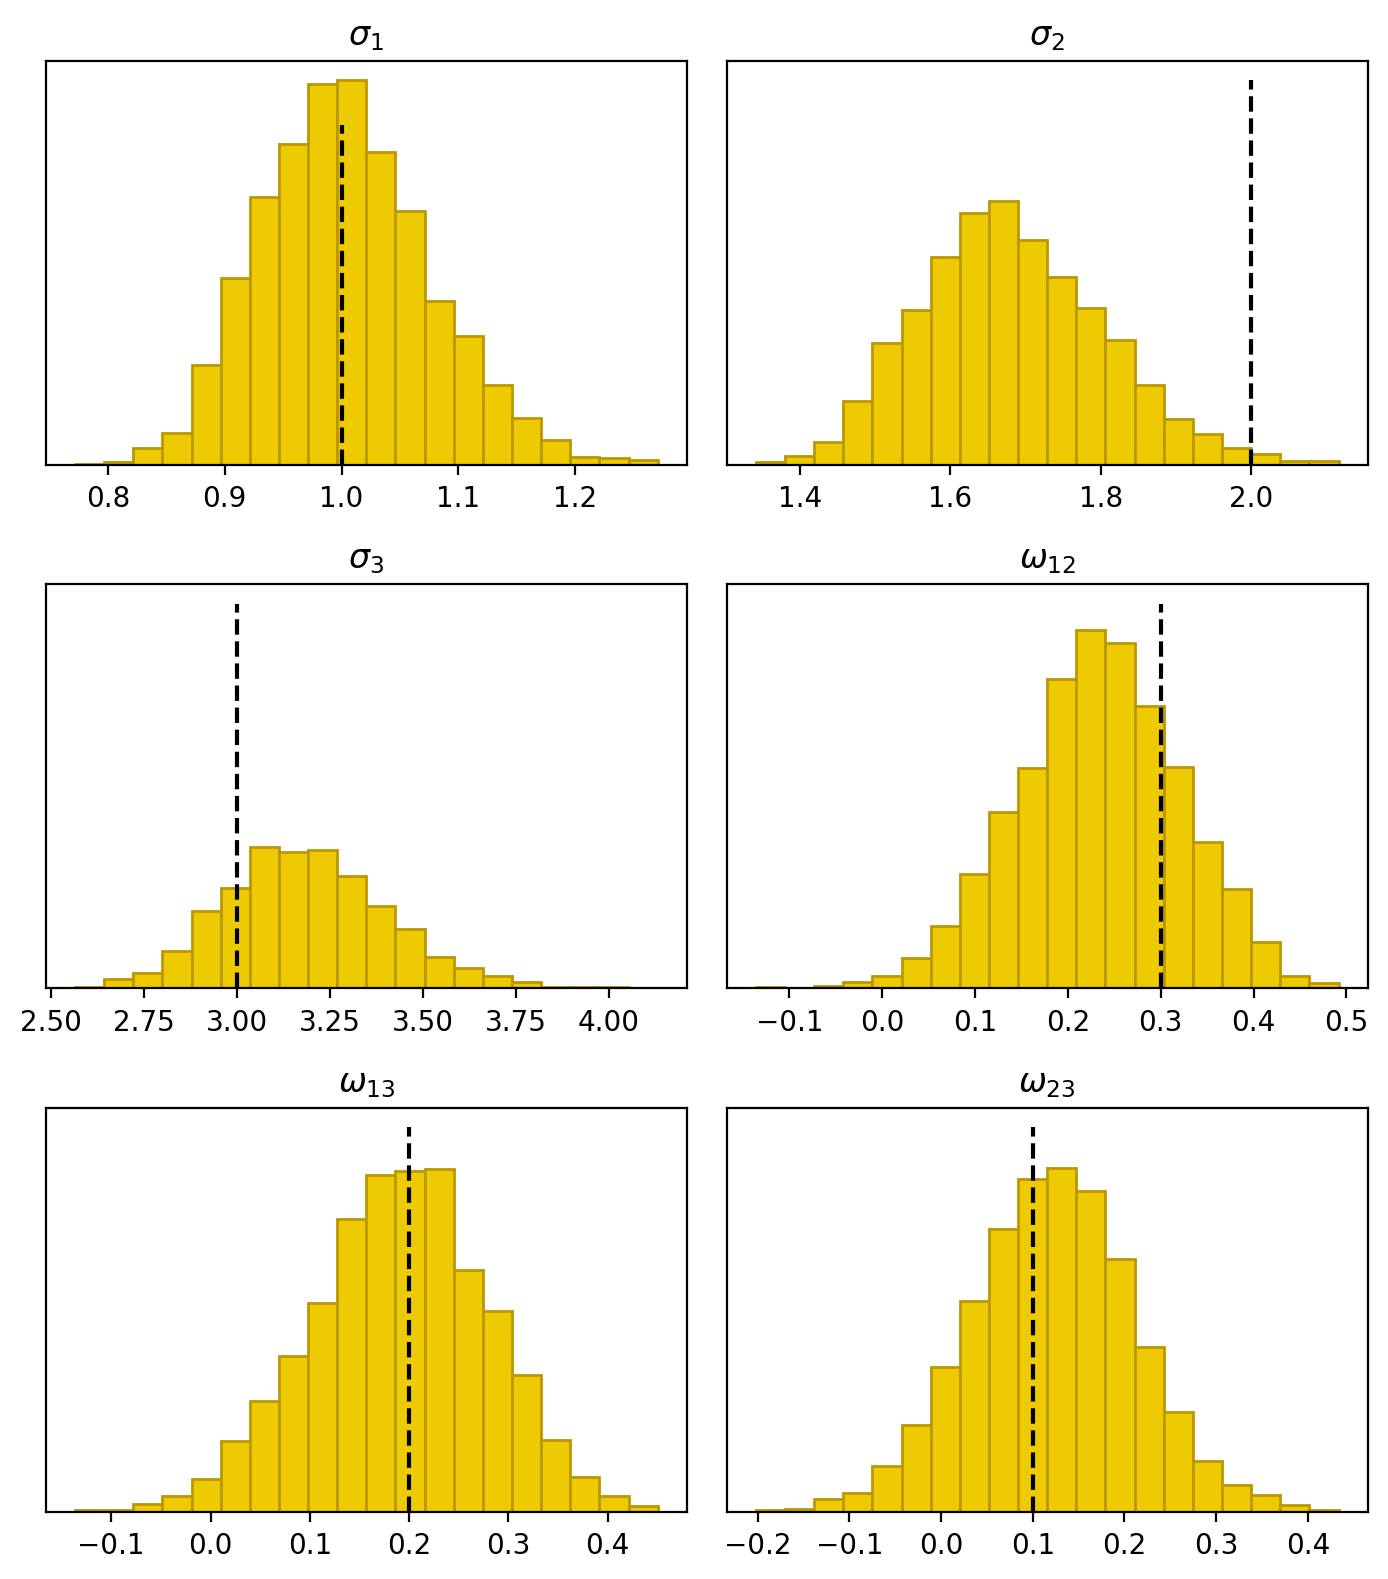

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(7, 8), squeeze=False)
axes_flat=axes.flatten()
for k in range(6):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(names_lt[k])
    ax.plot([tv[k],tv[k]],[0,5],linestyle='--',color='black')
    #ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

In [13]:
names=['sigma_1','sigma_2','sigma_3','omega_12','omega_13','omega_23']
nm_it=iter(names)
for col in zip(*y_sim):
    print(next(nm_it))
    print('Median: {:4.2f}'.format(np.median(col)))
    print('90% confidence interval: ',['{:4.2f}'.format(k) for k in np.percentile(col,[5,95],axis=0)])

sigma_1
Median: 1.00
90% confidence interval:  ['0.89', '1.13']
sigma_2
Median: 1.67
90% confidence interval:  ['1.50', '1.89']
sigma_3
Median: 3.17
90% confidence interval:  ['2.86', '3.56']
omega_12
Median: 0.23
90% confidence interval:  ['0.09', '0.38']
omega_13
Median: 0.19
90% confidence interval:  ['0.04', '0.33']
omega_23
Median: 0.12
90% confidence interval:  ['-0.03', '0.27']


In [16]:
Sigma_sim=fit.stan_variable('Sigma')
SIGMA=Sigma_sim[0]*0
for S in Sigma_sim:
    SIGMA += S
SIGMA/4000

array([[ 1.01266619,  0.39631477,  0.61359313],
       [ 0.39631477,  2.84585304,  0.65494926],
       [ 0.61359313,  0.65494926, 10.19769053]])

In [16]:
Sigma

matrix([[1. , 0.6, 0.6],
        [0.6, 4. , 0.6],
        [0.6, 0.6, 9. ]])